In [1]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator
import explainabilityModels

2022-10-18 11:20:36.660809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 11:20:40.801738: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-18 11:20:46.554996: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-18 11:20:46.555109: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
#hyperparameters and blank image and label generation
N = 6000
size = 64
big_blob_size = 8
big_blob_range = 2
labels = np.random.randint(3, size = N)
imgs = np.zeros((size, size, N))


In [3]:
#fill array with corresponding images
for i in range(N):
    if labels[i] == 0:
        x = generator.generate_new_blob_img(ellipse=True, size=size,num_big_blobs=4)
    elif labels[i] == 1:
        x = generator.generate_new_blob_img(ellipse = False, size = size, num_big_blobs=4)
    elif labels[i] == 2:
        x = generator.generate_new_blob_img(ellipse= False, size = size, num_big_blobs=0)
    imgs[:,:,i] = x

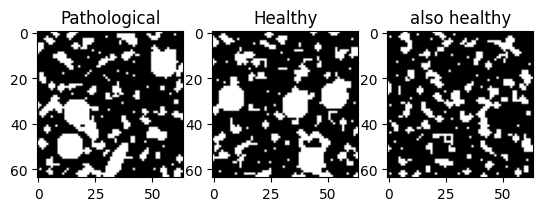

In [4]:
#display one pathological and one healthy image
fig, ax = plt.subplots(1,3)

path_img = imgs[:,:,np.where(labels == 0)[0][0]]
healthy_img = imgs[:,:,np.where(labels ==1)[0][0]]
healthy2_img = imgs[:,:,np.where(labels ==2)[0][0]]

ax[0].imshow(path_img, cmap=plt.cm.gray)
ax[1].imshow(healthy_img, cmap=plt.cm.gray)
ax[2].imshow(healthy2_img, cmap = plt.cm.gray)

ax[0].set_title("Pathological");
ax[1].set_title("Healthy");
ax[2].set_title('also healthy');

In [5]:
#prepare data for training
from sklearn.model_selection import train_test_split
X = np.expand_dims(imgs, -1)
X = np.transpose(X, (2,1,0,3))
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X.shape

(6000, 64, 64, 1)

In [6]:
# Model hyperparameters
num_classes = 3
input_shape = (size, size, 1)
batch_size = 64
epochs = 40
conv_size=(3,3)
save = True
# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [7]:
#create model

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=conv_size, activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=conv_size, activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=conv_size, activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

2022-10-18 11:20:59.375155: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2022-10-18 11:20:59.375213: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ancoramsi1
2022-10-18 11:20:59.375224: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ancoramsi1
2022-10-18 11:20:59.375357: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.85.2
2022-10-18 11:20:59.375386: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-18 11:20:59.375392: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 515.65.1 does not match DSO version 510.85.2 -- cannot find working devices in this configuration
2022-10-18 11:20:59.402569: I tensorflow/core/platform/cpu_feature_guard.cc:193] This Tensor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 64)       256       
 hNormalization)                                                 
                                                        

In [8]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/40
57/57 [==============================] - 14s 218ms/step - loss: 1.4934 - accuracy: 0.5788 - val_loss: 2.6872 - val_accuracy: 0.3109
Epoch 2/40
57/57 [==============================] - 13s 230ms/step - loss: 0.7563 - accuracy: 0.7330 - val_loss: 5.0813 - val_accuracy: 0.3109
Epoch 3/40
57/57 [==============================] - 13s 228ms/step - loss: 0.6001 - accuracy: 0.7734 - val_loss: 10.6886 - val_accuracy: 0.3109
Epoch 4/40
57/57 [==============================] - 13s 235ms/step - loss: 0.5421 - accuracy: 0.7952 - val_loss: 16.1304 - val_accuracy: 0.3109
Epoch 5/40
57/57 [==============================] - 14s 241ms/step - loss: 0.3700 - accuracy: 0.8519 - val_loss: 15.3217 - val_accuracy: 0.3109
Epoch 6/40
57/57 [==============================] - 14s 239ms/step - loss: 0.3546 - accuracy: 0.8590 - val_loss: 12.8012 - val_accuracy: 0.3109
Epoch 7/40
57/57 [==============================] - 14s 243ms/step - loss: 0.2903 - accuracy: 0.8903 - val_loss: 9.4479 - val_accuracy: 0.

In [9]:
if save:
    model.save("models/model40_3l_3c")

INFO:tensorflow:Assets written to: models/model40_3l_3c/assets


INFO:tensorflow:Assets written to: models/model40_3l_3c/assets


In [10]:
model = tf.keras.models.load_model("models/model40_3l_3c")

In [11]:
# Validate model
from sklearn.metrics import classification_report

label_names = ['Pathological', 'Healthy', 'also healthy']

score = model.evaluate(X_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

y_test_pred_DL_full = np.argmax(model.predict(X_test),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test, y_test_pred_DL_full, target_names=label_names))

Test loss: 0.03063039854168892
Test accuracy: 0.9934343695640564
62/62 [==============================] - 2s 29ms/step
              precision    recall  f1-score   support

Pathological       0.99      0.99      0.99       663
     Healthy       0.99      0.99      0.99       641
also healthy       1.00      1.00      1.00       676

    accuracy                           0.99      1980
   macro avg       0.99      0.99      0.99      1980
weighted avg       0.99      0.99      0.99      1980



In [12]:
import ipywidgets as widgets
#get array or predictions for test set

predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)


label_picker = widgets.Dropdown(
    options=[('Pathological', 0), ('Healthy', 1), ('also healthy', 2)],
    value=0,
    description='True Label:',
)
pred_picker = widgets.Dropdown(
    options=[('Pathological', 0), ('Healthy', 1), ('also healthy', 2)],
    value=0,
    description='Predicted Label:',
)
#pick what you want to see
display(label_picker)
display(pred_picker)


62/62 [==============================] - 1s 21ms/step


Dropdown(description='True Label:', options=(('Pathological', 0), ('Healthy', 1), ('also healthy', 2)), value=…

Dropdown(description='Predicted Label:', options=(('Pathological', 0), ('Healthy', 1), ('also healthy', 2)), v…

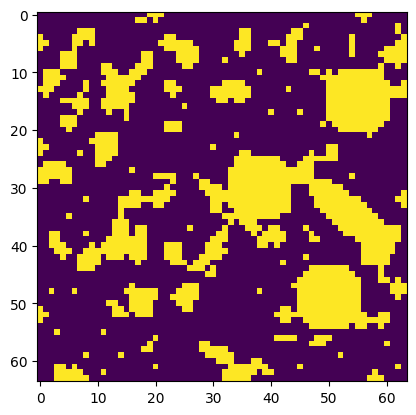

In [13]:
#show image
img = X_test[np.where((y_test == label_picker.value) & (predicted_classes == pred_picker.value))[0][6]]
plt.imshow(img)

In [14]:
heatmap = explainabilityModels.make_gradcam_heatmap(img, model, pred_index=0)

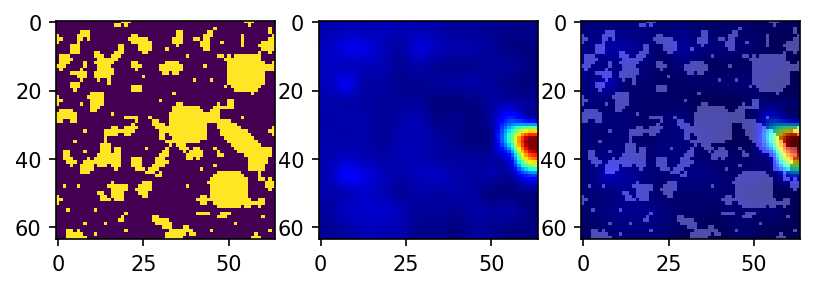

In [15]:
fig, ax = plt.subplots(1,3)
fig.set_dpi(150)
fig.tight_layout

ax[0].imshow(img)
ax[1].imshow(heatmap, cmap = 'jet')
ax[2].imshow(img, cmap = 'gray')
ax[2].imshow(heatmap, alpha = 0.7, cmap='jet')


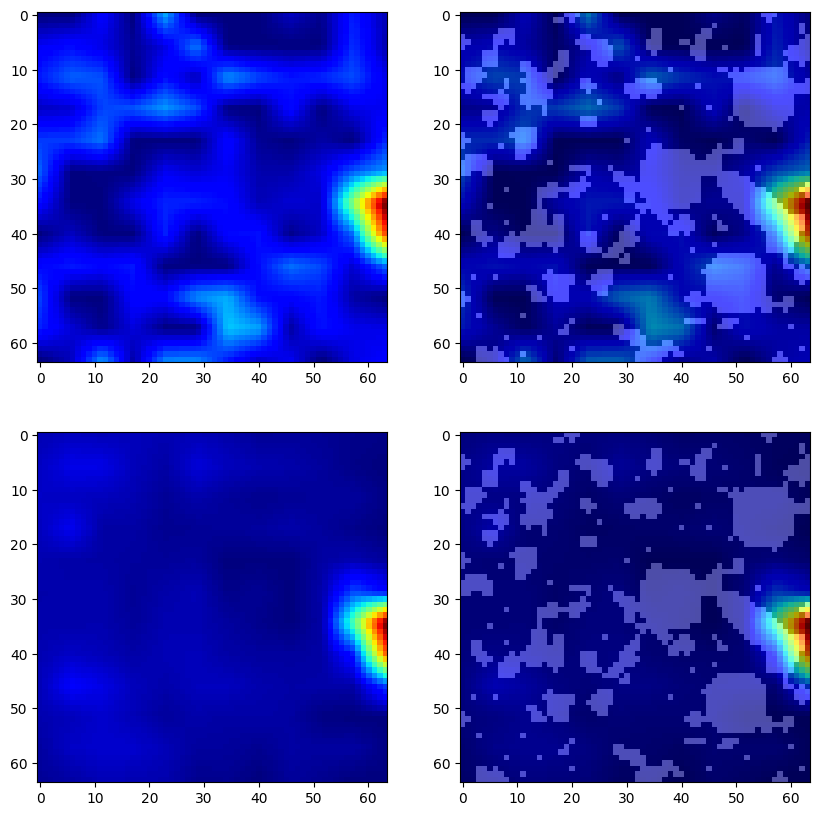

In [16]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

gradcam = GradcamPlusPlus(model, model_modifier=ReplaceToLinear(), 
            clone=True)
gradcam2 = Gradcam(model, model_modifier=ReplaceToLinear(), clone=True)
cam = gradcam(CategoricalScore(0), img).squeeze()
cam2 = gradcam2(CategoricalScore(0), img).squeeze()

fig, ax = plt.subplots(2,2)
fig.set_size_inches((10,10))
ax[0][0].imshow(cam, cmap = 'jet')
ax[0][1].imshow(img, cmap = 'gray')
ax[0][1].imshow(cam, cmap = 'jet', alpha = 0.7)

ax[1][0].imshow(cam2, cmap = 'jet')
ax[1][1].imshow(img, cmap = 'gray')
ax[1][1].imshow(cam2, cmap = 'jet', alpha = 0.7)


4/4 [==============================] - 0s 28ms/step


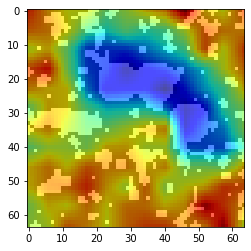

In [156]:
from tf_keras_vis.scorecam import Scorecam

scoreCam = Scorecam(model)

sC = scoreCam(CategoricalScore(2), img).squeeze()

plt.imshow(img, cmap = 'gray')
plt.imshow(sC, cmap = 'jet', alpha = 0.7)